In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate, integrate, special
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()

In [44]:
# df_pre_lockdown = df[(df["started_at"] < "2020-03-21")].dropna()
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_resi1 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-01")].dropna()
df_resi2 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-11-16")].dropna()
df_lockdown_relax = df[(df["started_at"] >= "2020-11-16") & (df["started_at"] < "2020-12-17")].dropna()
df_after_lockdown = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2023-10-01")].dropna()
df_aft_eto = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-02-23")].dropna()

In [56]:
df_lockdown_relax.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
2719735,41.910342,-87.670086,16.0,Paulina Ave & North Ave,2020-11-22 18:52:53,casual,4E13DE06D84C6092,electric_bike,41.918285,-87.636387,94.0,Clark St & Armitage Ave,2020-11-22 18:42:16,2.931713,"(41.918285, -87.63638666666667)","(41.9103415, -87.6700865)"
2719739,41.928799,-87.663851,190.0,Southport Ave & Wrightwood Ave,2020-11-23 12:46:55,casual,095D4B93585A6E39,electric_bike,41.894722,-87.632345,627.0,LaSalle Dr & Huron St,2020-11-23 12:27:15,4.599893,"(41.894722, -87.63234483333333)","(41.92879933333333, -87.66385116666666)"
2719740,41.902981,-87.631333,176.0,Clark St & Elm St,2020-11-23 17:10:23,casual,8827AEECE6A5505F,electric_bike,41.928731,-87.663872,190.0,Southport Ave & Wrightwood Ave,2020-11-23 16:51:32,3.932767,"(41.9287305, -87.66387166666667)","(41.90298066666666, -87.63133333333333)"
2719741,41.884479,-87.619542,195.0,Columbus Dr & Randolph St,2020-11-22 18:23:37,casual,D64DB04027BDA9D6,electric_bike,41.889246,-87.627978,47.0,State St & Kinzie St,2020-11-22 18:04:59,0.877858,"(41.889246, -87.6279785)","(41.884478666666666, -87.61954233333333)"
2719742,41.889292,-87.628151,47.0,State St & Kinzie St,2020-11-22 20:23:13,casual,33B3EFC817974995,electric_bike,41.884572,-87.619606,195.0,Columbus Dr & Randolph St,2020-11-22 19:54:50,0.881911,"(41.88457233333333, -87.61960566666667)","(41.88929183333333, -87.62815066666667)"


In [4]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        # df_tmpのstart_station_idをstr型に変換してからユニークな値を取得
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [45]:
node_lockdown, edge_lockdown, timestamp_lockdown = return_nm(df_lockdown)
node_resi1, edge_resi1, timestamp_resi1 = return_nm(df_resi1)
node_lockdown_relax, edge_lockdown_relax, timestamp_lockdown_relax = return_nm(df_lockdown_relax)
node_resi2, edge_resi2, timestamp_resi2 = return_nm(df_resi2)
node_after_lockdown, edge_after_lockdown, timestamp_after_lockdown = return_nm(df_after_lockdown)
node_aft_eto, edge_aft_eto, timestamp_aft_eto = return_nm(df_aft_eto)

In [46]:
lockdown = pd.DataFrame({'timestamp': timestamp_lockdown, 'node': node_lockdown, 'edge': edge_lockdown})
resi1 = pd.DataFrame({'timestamp': timestamp_resi1, 'node': node_resi1, 'edge': edge_resi1})
resi2 = pd.DataFrame({'timestamp': timestamp_resi2, 'node': node_resi2, 'edge': edge_resi2})
lockdown_relax = pd.DataFrame({'timestamp': timestamp_lockdown_relax, 'node': node_lockdown_relax, 'edge': edge_lockdown_relax})
after_lockdown = pd.DataFrame({'timestamp': timestamp_after_lockdown, 'node': node_after_lockdown, 'edge': edge_after_lockdown})
aft_eto = pd.DataFrame({'timestamp': timestamp_aft_eto, 'node': node_aft_eto, 'edge': edge_aft_eto})

In [8]:
def Model1(M,kappa):
    def Np(kappa):
        return (1+np.sqrt(1+32*M/kappa))/2
    N = Np(kappa)*(1-2/kappa/Np(kappa)*(1 - (1-kappa/2)**Np(kappa)))
    return N


def Model2(M,Np):
    def kappa(Np):
        return 8*M/Np/(Np-1)
    N = Np*(1 - 2/kappa(Np)/Np*(1 - (1-kappa(Np)/2)**Np))
    return N

In [64]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

In [9]:
def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N

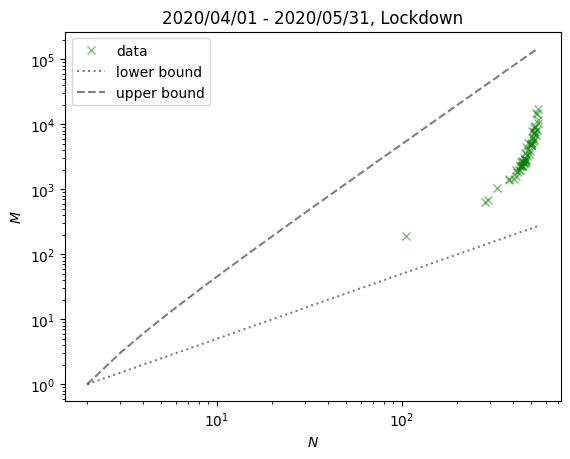

In [55]:
plt.Figure(figsize=(14,7))

N = lockdown['node']
M = lockdown['edge']

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")
#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/04/01 - 2020/05/31, Lockdown")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

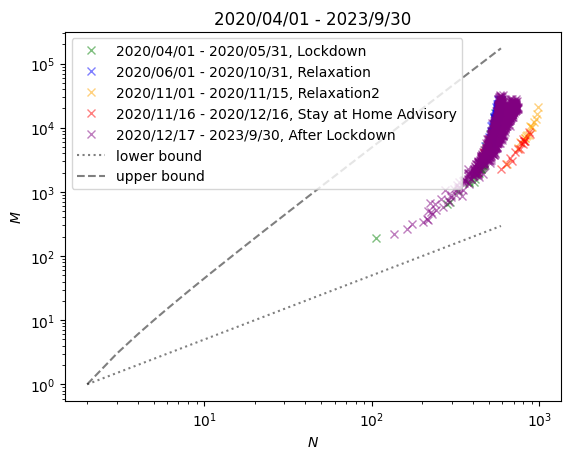

In [52]:
plt.Figure(figsize=(18,9))
plt.rcParams["font.size"] = 10

lock_N = lockdown['node']
lock_M = lockdown['edge']

resi1_N = resi1['node']
resi1_M = resi1['edge']

resi2_N = resi2['node'] 
resi2_M = resi2['edge']

lockdown_relax_N = lockdown_relax['node']
lockdown_relax_M = lockdown_relax['edge']

after_lockdown_N = after_lockdown['node']
after_lockdown_M = after_lockdown['edge']


x = np.arange(2, np.max(resi1_N))
y = np.arange(1, np.max(resi1_M))

plt.plot(lock_N, lock_M, "x", c="green", alpha=0.5, label="2020/04/01 - 2020/05/31, Lockdown")
plt.plot(resi1_N, resi1_M, "x", c="blue", alpha=0.5, label="2020/06/01 - 2020/10/31, Relaxation")
plt.plot(resi2_N, resi2_M, "x", c="orange", alpha=0.5, label="2020/11/01 - 2020/11/15, Relaxation2")
plt.plot(lockdown_relax_N, lockdown_relax_M, "x", c="red", alpha=0.5, label="2020/11/16 - 2020/12/16, Stay at Home Advisory")
plt.plot(after_lockdown_N, after_lockdown_M, "x", c="purple", alpha=0.5, label="2020/12/17 - 2023/9/30, After Lockdown")
#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/04/01 - 2023/9/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

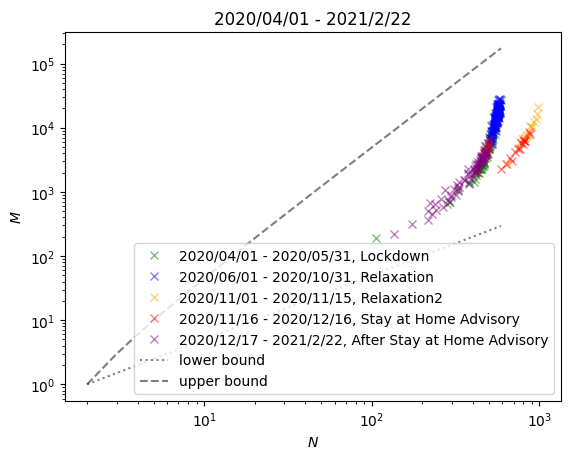

In [53]:
plt.Figure(figsize=(14,7))

lock_N = lockdown['node']
lock_M = lockdown['edge']

resi1_N = resi1['node']
resi1_M = resi1['edge']

resi2_N = resi2['node'] 
resi2_M = resi2['edge']

lockdown_relax_N = lockdown_relax['node']
lockdown_relax_M = lockdown_relax['edge']

after_lockdown_N = after_lockdown['node']
after_lockdown_M = after_lockdown['edge']

aft_eto_N = aft_eto['node']
aft_eto_M = aft_eto['edge']


x = np.arange(2, np.max(resi1_N))
y = np.arange(1, np.max(resi1_M))

plt.plot(lock_N, lock_M, "x", c="green", alpha=0.5, label="2020/04/01 - 2020/05/31, Lockdown")
plt.plot(resi1_N, resi1_M, "x", c="blue", alpha=0.5, label="2020/06/01 - 2020/10/31, Relaxation")
plt.plot(resi2_N, resi2_M, "x", c="orange", alpha=0.5, label="2020/11/01 - 2020/11/15, Relaxation2")
plt.plot(lockdown_relax_N, lockdown_relax_M, "x", c="red", alpha=0.5, label="2020/11/16 - 2020/12/16, Stay at Home Advisory")
#plt.plot(after_lockdown_N, after_lockdown_M, "x", c="purple", alpha=0.5, label="2020/12/17 - 2021/4/22, After Emergency Travel Order")
plt.plot(aft_eto_N, aft_eto_M, "x", c="purple", alpha=0.5, label="2020/12/17 - 2021/2/22, After Stay at Home Advisory")
# plt.plot(after_lockdown_N, after_lockdown_M, "x", c="purple", alpha=0.5, label="2020/12/17 - 2023/9/30, After Lockdown")
#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/04/01 - 2021/2/22")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

## アクティビティの推計
### Lockdown期間
2020/4~2020/5/31

In [78]:
params, _ = optimize.curve_fit(Model1, lockdown['edge'], lockdown['node'], p0=[0.05])
print(params[0])

0.17461087202683556


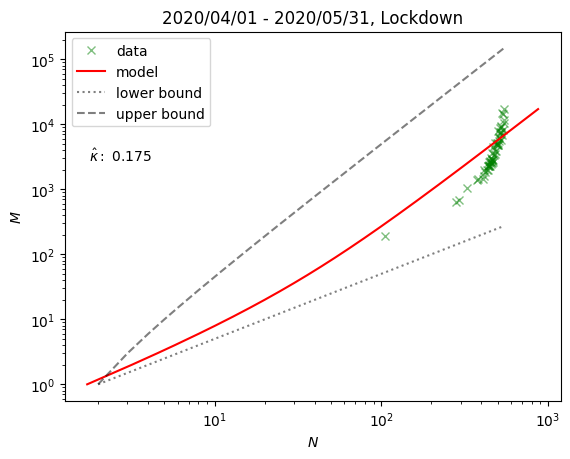

In [61]:
plt.Figure(figsize=(14,7))

N = lockdown['node']
M = lockdown['edge']
kappa = params[0]
kappa = round(kappa, 3)

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")
plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/04/01 - 2020/05/31, Lockdown")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_50842/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_50842/2291635319.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


[0.00668937 0.01396097]


In [70]:
params, _ = optimize.curve_fit(Model2, lockdown['edge'], lockdown['node'], p0=[0.01])
print(params[0])

0.7930517284479657


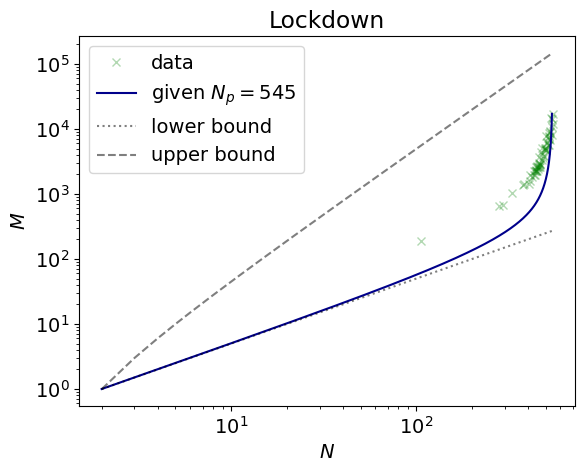

In [75]:
kappa = params[0]
kappa = round(kappa, 3)

# plt.rcParams["font.size"]=14
Np = np.max(N)
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")
plt.plot(Model2(y,Np), y, "-", c="darkblue", label = r"given $N_p=$"+str(Np))
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("Lockdown")
plt.legend()

In [101]:
N = lockdown['node']
M = lockdown['edge']

Np = 596 # histrical dataから求めたNp
params, _ = optimize.curve_fit(Model3_fixed, lockdown['edge'], lockdown['node'], p0=[1, 1])
print(params)
alpha = params[0]
beta = params[1]

[0.47089493 9.70729278]


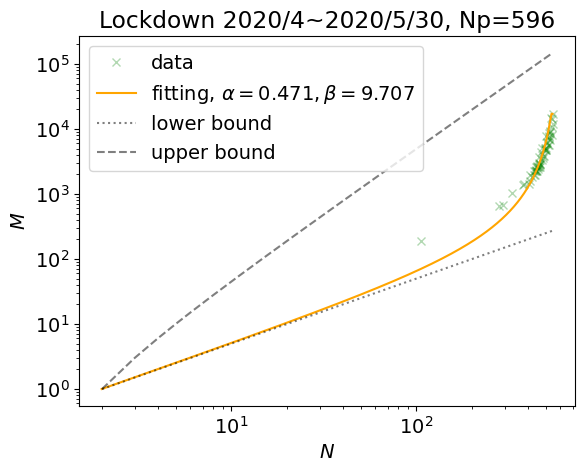

In [102]:
# alpha = round(alpha, 5)
# beta = round(beta, 5)

plt.Figure(figsize=(14,7))
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")


# model
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
# plt.text(0.05, 0.55, r'$\hat{\alpha}:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
# plt.text(0.05, 0.50, r'$\hat{\beta}:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)

"""
alpha = 0.5
beta = 0.048
plt.plot(Model3(y), y, "-", c="red", label=f"given $\\alpha={alpha}, \\beta={beta}$")

alpha = 1
beta = 0.048
plt.plot(Model3(y), y, "-", c="darkblue", label=f"given $\\alpha={alpha}, \\beta={beta}$")


alpha = 2
beta = 0.048
plt.plot(Model3(y), y, "-", c="green", label=f"given $\\alpha={alpha}, \\beta={beta}$")

alpha = 2.5
beta = 0.048
plt.plot(Model3(y), y, "-", c="purple", label=f"given $\\alpha={alpha}, \\beta={beta}$")


alpha = 3
beta = 0.01
plt.plot(Model3(y), y, "-", c="black", label=f"given $\\alpha={alpha}, \\beta={beta}$")
"""

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("Lockdown 2020/4~2020/5/30, Np="+str(Np))
plt.legend()

## Lockdownと自宅待機勧告の間

In [109]:
Np = 673 # histrical dataから求めたNp
params, _ = optimize.curve_fit(Model3_fixed, resi1['edge'], resi1['node'], p0=[0.5, 3])
print(params)

[0.35129455 5.33725394]


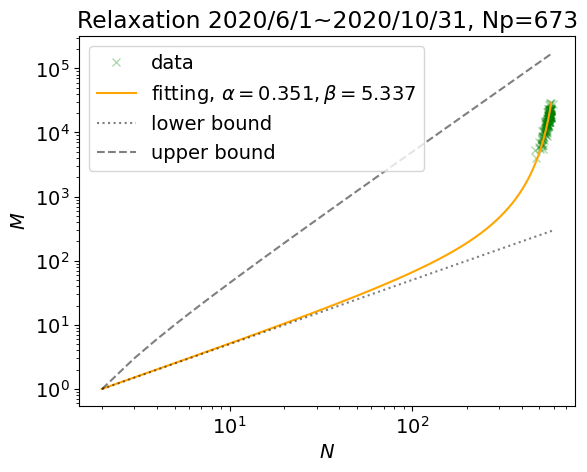

In [112]:
# alpha = round(alpha, 5)
# beta = round(beta, 5)

plt.Figure(figsize=(14,7))
N = resi1['node']
M = resi1['edge']

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

alpha = params[0]
beta = params[1]

# model
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
# plt.text(0.05, 0.55, r'$\hat{\alpha}:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
# plt.text(0.05, 0.50, r'$\hat{\beta}:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)

"""
alpha = 0.5
beta = 0.048
plt.plot(Model3(y), y, "-", c="red", label=f"given $\\alpha={alpha}, \\beta={beta}$")

alpha = 1
beta = 0.048
plt.plot(Model3(y), y, "-", c="darkblue", label=f"given $\\alpha={alpha}, \\beta={beta}$")


alpha = 2
beta = 0.048
plt.plot(Model3(y), y, "-", c="green", label=f"given $\\alpha={alpha}, \\beta={beta}$")

alpha = 2.5
beta = 0.048
plt.plot(Model3(y), y, "-", c="purple", label=f"given $\\alpha={alpha}, \\beta={beta}$")


alpha = 3
beta = 0.01
plt.plot(Model3(y), y, "-", c="black", label=f"given $\\alpha={alpha}, \\beta={beta}$")
"""

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("Relaxation 2020/6/1~2020/10/31, Np="+str(Np))
plt.legend()

## 2020/11~直前

In [128]:
Np = 670 # histrical dataから求めたNp
params, _ = optimize.curve_fit(Model3_fixed, resi2['edge'], resi2['node'], p0=[0.2, 0.1], maxfev=10000)
print(params)

[ 8.20803127 38.64975504]


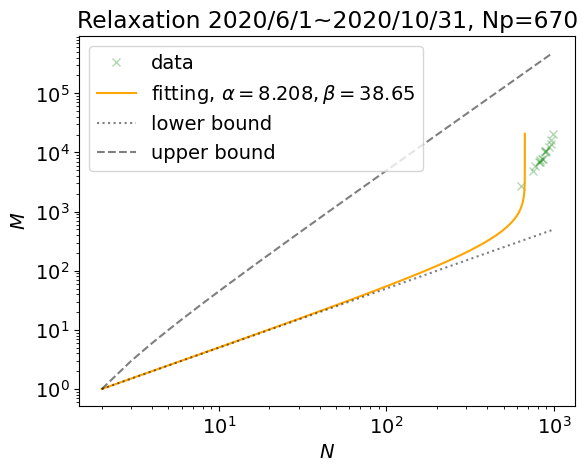

In [129]:
alpha = params[0]
beta = params[1]

# alpha = round(alpha, 5)
# beta = round(beta, 5)

plt.Figure(figsize=(14,7))
N = resi2['node']
M = resi2['edge']

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

alpha = params[0]
beta = params[1]

# model
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
# plt.text(0.05, 0.55, r'$\hat{\alpha}:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
# plt.text(0.05, 0.50, r'$\hat{\beta}:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)

"""
alpha = 0.5
beta = 0.048
plt.plot(Model3(y), y, "-", c="red", label=f"given $\\alpha={alpha}, \\beta={beta}$")

alpha = 1
beta = 0.048
plt.plot(Model3(y), y, "-", c="darkblue", label=f"given $\\alpha={alpha}, \\beta={beta}$")


alpha = 2
beta = 0.048
plt.plot(Model3(y), y, "-", c="green", label=f"given $\\alpha={alpha}, \\beta={beta}$")

alpha = 2.5
beta = 0.048
plt.plot(Model3(y), y, "-", c="purple", label=f"given $\\alpha={alpha}, \\beta={beta}$")


alpha = 3
beta = 0.01
plt.plot(Model3(y), y, "-", c="black", label=f"given $\\alpha={alpha}, \\beta={beta}$")
"""

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("Relaxation 2020/6/1~2020/10/31, Np="+str(Np))
plt.legend()